In [99]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp
from scipy.optimize import root

from mmfsim.grid import Grid
from mmfsim.fiber import GrinFiber, StepIndexFiber
from mmfsim.modes import StepIndexLPMode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


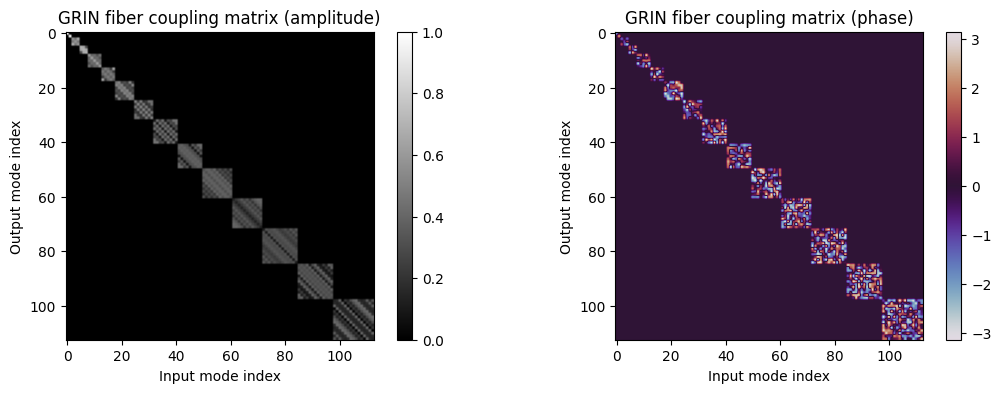

In [100]:
fiber = GrinFiber()
matrix = fiber.modes_coupling_matrix(complex=True, degen=True)
GrinFiber.plot_coupling_matrix(matrix, complex=True)
plt.show()

In [141]:
fiber = StepIndexFiber(radius=50e-6, wavelength=1064e-9)
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:176: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:175: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)


StepIndexFiber instance with:
  - Radius: 50.0 um
  - Core index: 1.465
  - Cladding index: 1.445
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.241
  - Number of guided LP modes: 649
  - Number of guided LP modes (counting degenerates): 1275
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46497798  0.          0.          1.        ]
 [ 1.4649441   2.          1.          1.        ]
 [ 1.46489958  4.          2.          1.        ]
 [ 1.46488399  1.          0.          2.        ]
 [ 1.46484502  6.          3.          1.        ]
 [ 1.46481261  3.          1.          2.        ]
 [ 1.46478076  8.          4.          1.        ]
 [ 1.46473025  5.          2.          2.        ]
 [ 1.46471488  2.          0.          3.        ]
 [ 1.46470706 10.          5.          1.        ]]


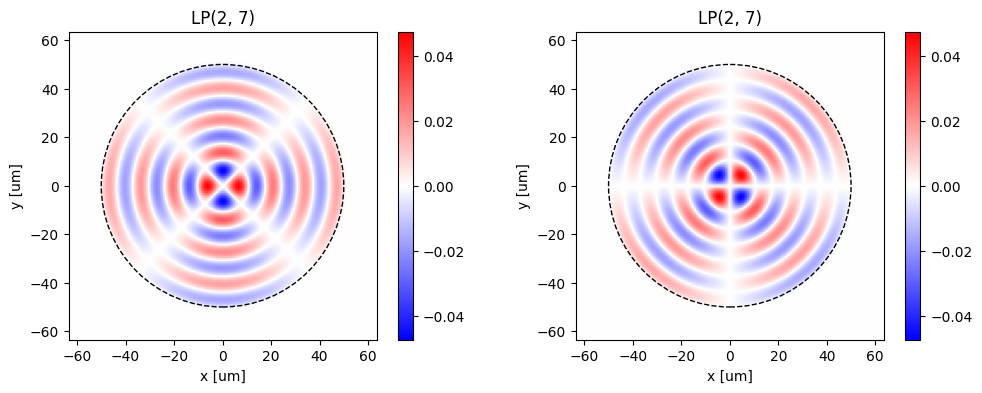

In [160]:
grid = Grid(pixel_size=1e-6)

LPMode = StepIndexLPMode(2, 7)
LPMode.compute(fiber, grid)
LPMode.plot()

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'GRIN fiber speckle (10 modes)'}, xlabel='x [um]', ylabel='x [um]'>,
 <matplotlib.image.AxesImage at 0x1c8db07d340>)

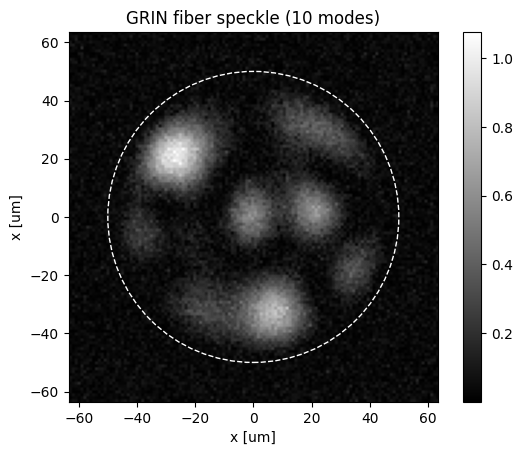

In [181]:
from mmfsim.speckle import StepIndexSpeckle

speckle = StepIndexSpeckle(fiber, grid, 10)
speckle.compose()
speckle.plot(cmap='gray')

(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Energy percentage on LP modes (25 modes, total energy: 100.0%)'}, xlabel='LP$_{n,m}$ mode', ylabel='Energy percentage [%]'>,
 <BarContainer object of 25 artists>)

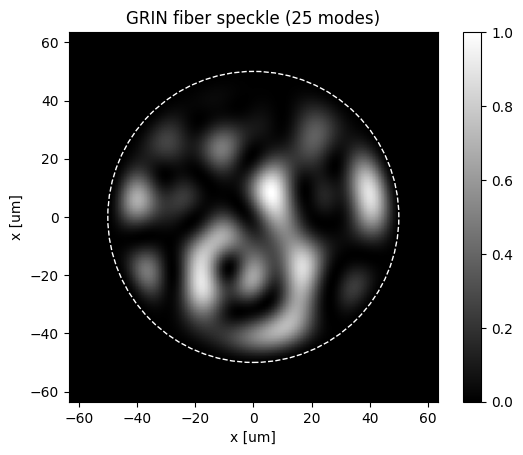

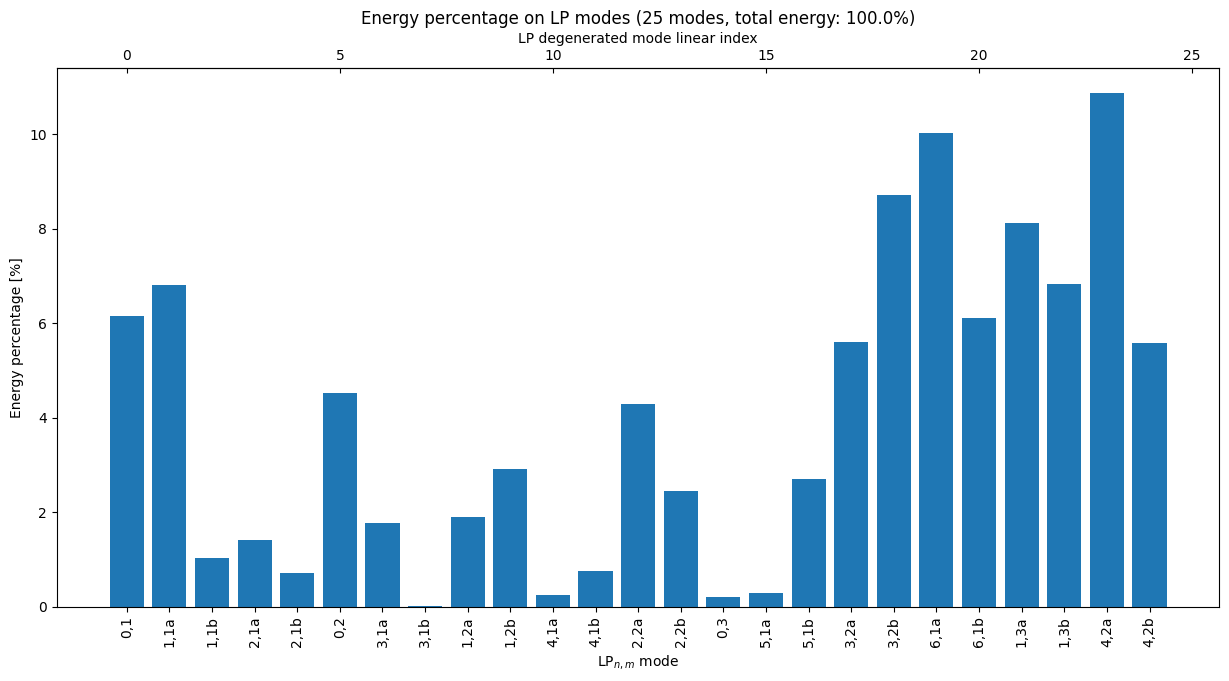

In [194]:
from mmfsim.speckle import DegenStepIndexSpeckle

speckle = DegenStepIndexSpeckle(fiber, grid, 25)
speckle.compose()
speckle.plot(cmap='gray')
speckle.plot_coefficients()

In [97]:
# print(fiber._prop_constants)



print(n_idx)
print(m_idx) 
print(np.intersect1d(n_idx, m_idx))

[[2]
 [7]]
[[ 0]
 [ 1]
 [ 2]
 [ 4]
 [ 6]
 [ 9]
 [11]]
[2]


In [28]:


n_core = 1.465
n_clad = 1.445
r_core = 10e-6
wavelength = 1.064e-6

n_samples = 128 # Number of spatial samples
px_size = 0.5e-6
win_size = n_samples*px_size # Window dimension
step = win_size / n_samples
x = np.linspace(-win_size/2, +win_size/2+step, n_samples)
X, Y = np.meshgrid(x,x)
R = np.sqrt(np.square(X) + np.square(Y))
A = np.arctan2(Y, X)

In [29]:
NA = np.sqrt(n_core ** 2 - n_clad ** 2)
V = 2 * np.pi * r_core * NA / wavelength

In [33]:
lbda = wavelength
a = r_core
n1 = n_core
tol = 1e-9
v = V
jv = sp.jv
kn = sp.kn

roots = [0]
m = 0
modes_number = 0

modes = {
    'beta': [],
    'u': [],
    'w': [],
    'm': [],
    'l': [],
    'number': 0,
}

interval = np.arange(np.spacing(10), v - np.spacing(10), v * 1e-4)


while len(roots):

    def root_func(u):
        w = np.sqrt(v**2 - u**2)
        return jv(m, u) / (u * jv(m - 1, u)) + kn(m, w) / (w * kn(m - 1, w))

    guesses = np.argwhere(np.abs(np.diff(np.sign(root_func(interval)))))
    froot = lambda x0: root(root_func, x0, tol=tol)
    sols = map(froot, interval[guesses])
    roots = [s.x for s in sols if s.success]

    # remove solution outside the valid interval, round the solutions and remove duplicates
    roots = np.unique(
        [np.round(r / tol) * tol for r in roots if (r > 0 and r < v)]
    ).tolist()
    roots_num = len(roots)

    if roots_num:
        degeneracy = 1# if m == 0 else 2

        modes['beta'] = modes['beta'] + [np.sqrt((2 * np.pi / lbda * n1) ** 2 - (r / a) ** 2) for r in roots] * degeneracy
        modes['u'] = modes['u'] + roots * degeneracy
        modes['w'] = modes['w'] + [np.sqrt(v**2 - r**2) for r in roots] * degeneracy
        modes['number'] += roots_num * degeneracy
        modes['m'] = modes['m'] + [m] * roots_num * degeneracy
        modes['l'] = modes['l'] + [x + 1 for x in range(roots_num)] * degeneracy

    m += 1

C:\Users\saucourt\AppData\Local\Temp\ipykernel_17468\2947694244.py:28: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)


In [34]:
sorted_idx = np.flip(np.argsort(modes['beta']))

modes['beta'] = np.array(modes['beta'])[sorted_idx]
modes['n_eff'] = modes['beta'] * wavelength / (2 * np.pi)
modes['u'] = np.array(modes['u'])[sorted_idx]
modes['w'] = np.array(modes['w'])[sorted_idx]
modes['m'] = np.array(modes['m'])[sorted_idx]
modes['l'] = np.array(modes['l'])[sorted_idx]

25.0
16.5
1.4645060056272436 1.4465868252737204


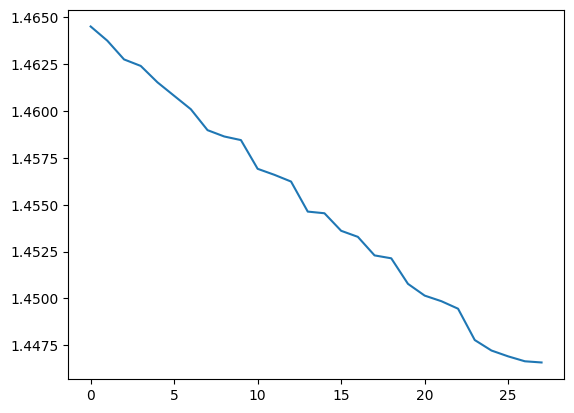

In [35]:
import matplotlib.pyplot as plt

plt.plot(modes['beta'] * wavelength / (2 * np.pi))

print(np.floor(np.square(V) / 8))
print(np.sum(modes['m']==0) + np.sum(modes['m']!=0)/2)
print(np.max(modes['n_eff']), np.min(modes['n_eff']))

LP(5, 2)


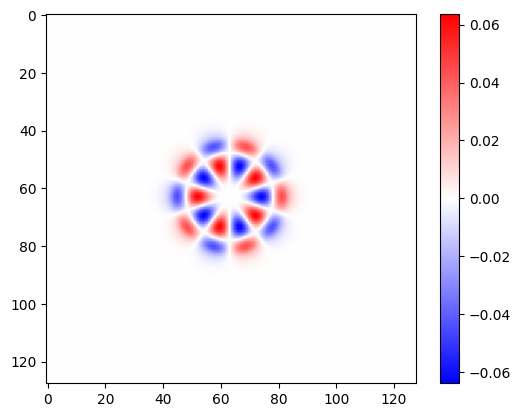

In [54]:
def calc_mode(modes, idx, X, Y, r_core):
    R = np.sqrt(np.square(X) + np.square(Y))
    R[R < np.finfo(np.float32).eps] = np.finfo(np.float32).eps
    An = np.arctan2(Y, X)
    
    core = R <= r_core
    clad = R > r_core

    m = modes['m'][idx]
    l = modes['l'][idx]
    u = modes['u'][idx]
    w = modes['w'][idx]
    beta = modes['beta'][idx]

    print(f"LP{m, l}")

    Et = sp.jv(m, u / r_core * R) / sp.jv(m, u) * core + sp.kn(m, w / r_core * R) / sp.kn(m, w) * clad

    if m == 0:
        idx = np.unravel_index(np.argmax(np.abs(Et)), shape=Et.shape)
        if Et[idx[0], idx[1]] < 0:
            Et *= -1
        mode = Et
    else:
        mode = Et * np.cos(m * An)

    mode /= np.sqrt(np.sum(np.abs(mode) ** 2))
    return mode


mode = calc_mode(modes, 18, X, Y, r_core)
plt.imshow(mode, cmap='bwr')
plt.colorbar()

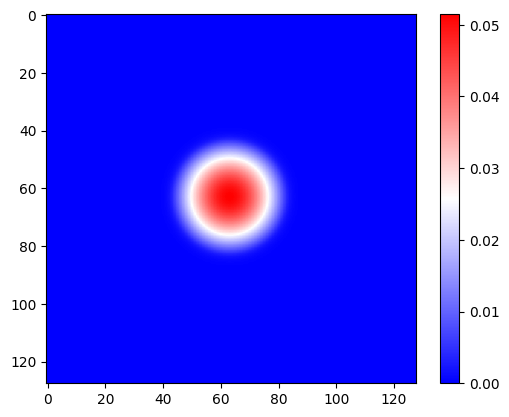